In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from netCDF4 import Dataset
from sklearn.decomposition import PCA
from matplotlib.colors import LogNorm
from sklearn.preprocessing import StandardScaler

<br>

<h3 align="left">Read in the data</h3>

In [2]:
def read_netCDF4_data(filename):
    with Dataset(filename) as rootgrp:
        latitude = rootgrp['latitude'][:]
        longitude = rootgrp['longitude'][:]
        level = rootgrp['level'][:]
        time = rootgrp['time'][:]
        specific_humidity = rootgrp['q'][:][:][:][:]
        temperature = rootgrp['t'][:][:][:][:]
    return latitude, longitude, level, time, specific_humidity, temperature

In [3]:
latitude, longitude, level, time, specific_humidity, temperature = read_netCDF4_data("/home/jaminkiukkonen/Downloads/test_data.nc")

<br>

<h3 align="left">Creating a matrix with all of the temperature profiles</h3>

In [4]:
def create_temperature_profiles(t):
    """
    This function creates temperature profiles such that
    each column represent one pressure level.
    For example, the first column has the temperatures associated
    with pressure level 1.
    
    parameters:
        t: a 4D tensor containing time, pressure level, latitude, longitude.
        
    returns:
        2D matrix where each column represents one pressure level.
    """
    i = 0
    T_profiles = np.zeros((t[:, 0, :, :].size, t[0, :, 0, 0].size), float)
    for day in range(0, len(time)):
        print(day)
        for lat in range(0, len(latitude)):
            for lon in range(0, len(longitude)):
                T_profiles[i, :] = t[day, :, lat, lon][None, :]
                i += 1
    return T_profiles

In [5]:
temperature_profiles = create_temperature_profiles(temperature)

0
1
2
3
4
5
6


In [6]:
temperature_profiles.shape

(7267680, 37)

<br>

<h3 align="left">PCA for Clustering</h3>

[Sklearn PCA](https://scikit-learn.org/1.4/modules/generated/sklearn.decomposition.PCA.html)

In [7]:
# Scale the data
scaler = StandardScaler()
scaled_temperature_profiles = scaler.fit_transform(temperature_profiles)

- [Problem with scaling in PCA](https://stats.stackexchange.com/questions/105592/not-normalizing-data-before-pca-gives-better-explained-variance-ratio)

In [12]:
pca = PCA(n_components=None)
pca_results = pca.fit_transform(scaled_temperature_profiles)

- Specify n_components=None so that we keep all of the 37 original features.
- We want to keep all of the 37 original features because we want to see if we can use PCA for making meaningful clusters.
- Notice that we with the PCA model with the scaled temperature profiles.

In [13]:
pca_results.shape

(7267680, 37)

In [14]:
np.round(np.mean(pca_results, axis=0), 3)

array([ 0., -0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0.,
        0.,  0.,  0., -0., -0.,  0., -0.,  0., -0., -0.,  0.,  0.,  0.,
        0., -0.,  0.,  0.,  0., -0., -0.,  0.,  0., -0.,  0.])

In [15]:
np.round(np.corrcoef(pca_results.T), 3)

array([[ 1.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  1., -0., ...,  0.,  0., -0.],
       [ 0., -0.,  1., ..., -0.,  0., -0.],
       ...,
       [ 0.,  0., -0., ...,  1., -0., -0.],
       [-0.,  0.,  0., ..., -0.,  1.,  0.],
       [ 0., -0., -0., ..., -0.,  0.,  1.]])

- The principal components are constructed in such a way that they are *uncorrelated* with each other.

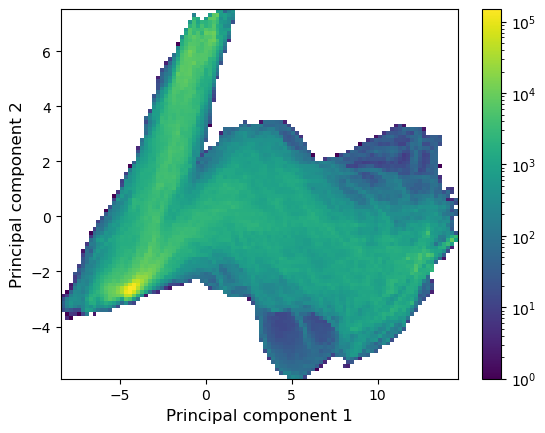

In [16]:
plt.hist2d(pca_results[:, 0], pca_results[:, 1], bins=100, norm=LogNorm())
plt.colorbar()
plt.xlabel('Principal component 1', size=12)
plt.ylabel('Principal component 2', size=12);

- The yellow dot clearly represents the most common temperature profile.

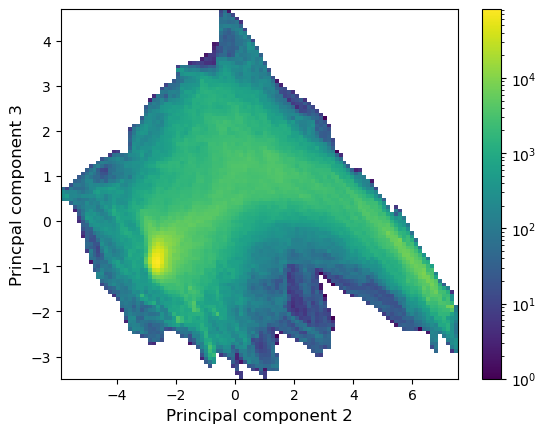

In [17]:
plt.hist2d(pca_results[:, 1], pca_results[:, 2], bins=100, norm=LogNorm())
plt.colorbar()
plt.xlabel('Principal component 2', size=12)
plt.ylabel('Princpal component 3', size=12);

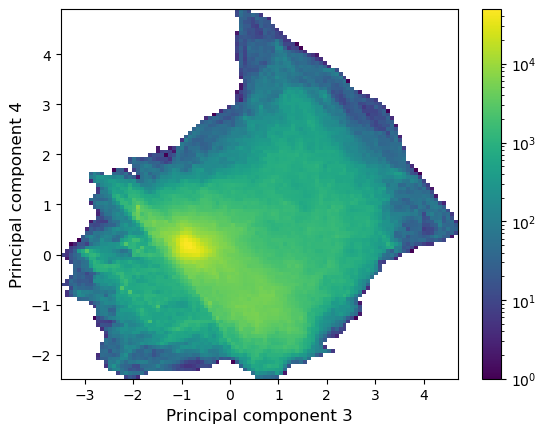

In [18]:
plt.hist2d(pca_results[:, 2], pca_results[:, 3], bins=100, norm=LogNorm())
plt.colorbar()
plt.xlabel('Principal component 3', size=12)
plt.ylabel('Principal component 4', size=12);

<br>

<h3 align="left">Explained Variance</h3>

In [21]:
explained_var = pca.explained_variance_ratio_
explained_var

array([6.86016861e-01, 2.27828456e-01, 3.59897967e-02, 2.16911714e-02,
       8.87928304e-03, 4.19074822e-03, 2.97477633e-03, 2.78836767e-03,
       2.02699152e-03, 1.29201544e-03, 1.05147239e-03, 8.58962766e-04,
       7.01194809e-04, 5.24320443e-04, 4.12111009e-04, 3.98342667e-04,
       3.11531669e-04, 2.90568179e-04, 2.53662654e-04, 2.31005323e-04,
       1.94042697e-04, 1.89474311e-04, 1.50281391e-04, 1.41215610e-04,
       1.24719472e-04, 9.96910394e-05, 8.20580683e-05, 6.42062338e-05,
       5.39643323e-05, 4.84400903e-05, 3.57192407e-05, 2.65573100e-05,
       2.57556686e-05, 1.80270547e-05, 1.40011798e-05, 1.24984199e-05,
       7.70807945e-06])

In [22]:
explained_var.shape

(37,)

In [20]:
print(f'Number of original components: {temperature_profiles.shape[1]}')

Number of original components: 37


- Each of the elements in the *explained_var* array tell much variance of the original data the principal component in question explains.
- Note that the explained variances are sorted in descending order (so for example, the principal component that explains the most of the variance in the original data, is in the index position 0 etc).

In [23]:
explained_var[0] + explained_var[1]

0.9138453175154704

- Two of the first principal components explain approx. 91.4% of the variance of the original data.

In [57]:
def var_explained_by_n_components(arr, n):
    """
    This function tells how much variance of the original data
    (temperature_profiles) can be explained by n principal components.
    
    parameters:
        arr: array containing the explained variances of the princpal components.
        n: number of principal components.
    
    returns:
        The amount of variance that can be explained by n principal components.
    """
    explained_sigmasq = np.round(np.sum(arr[:n]), 3)
    print(f'{explained_sigmasq} of the variance of the '
          f'original data can be explained by {n} principal components.')

In [58]:
for i in range(1, 9):
    var_explained_by_n_components(explained_var, i)
    print()

0.686 of the variance of the original data can be explained by 1 principal components.

0.914 of the variance of the original data can be explained by 2 principal components.

0.95 of the variance of the original data can be explained by 3 principal components.

0.972 of the variance of the original data can be explained by 4 principal components.

0.98 of the variance of the original data can be explained by 5 principal components.

0.985 of the variance of the original data can be explained by 6 principal components.

0.988 of the variance of the original data can be explained by 7 principal components.

0.99 of the variance of the original data can be explained by 8 principal components.



In [60]:
# Plot explained variance with different number of principal components

explained_var = np.zeros((scaled_temperature_profiles.shape[1], 0))

for n in range(1, scaled_temperature_profiles.shape[1]+1):
    pca_model = PCA(n_components=n)
    pca_model.fit(scaled_temperature_profiles)
    sum_explained_var = np.sum(pca_model.explained_variance_ratio_)
    explained_var = np.append(explained_var, sum_explained_var)

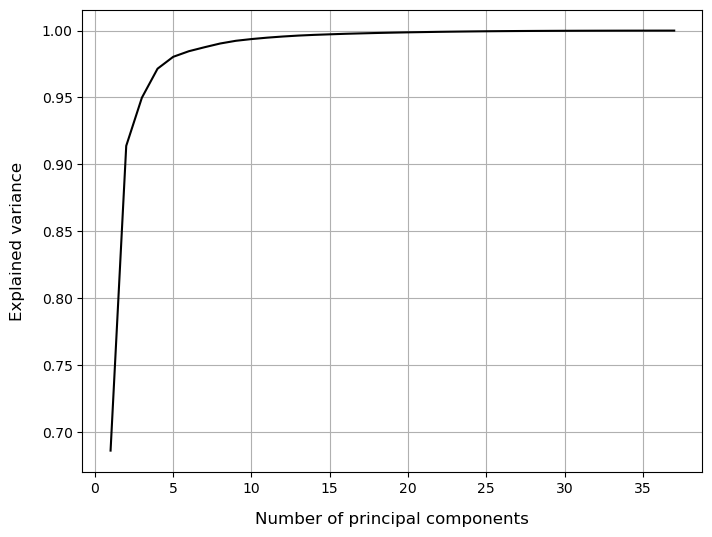

In [62]:
plt.figure(figsize=(8,6), dpi=100)
plt.plot(range(1, temperature_profiles.shape[1]+1), explained_var, color='black')
plt.xlabel('Number of principal components', size=12, labelpad=12)
plt.ylabel('Explained variance', size=12, labelpad=12)
plt.grid(True);
#plt.savefig('variance-explained')